# <center> [Adult salaries](https://archive.ics.uci.edu/ml/datasets/adult): Decission Tree
### <center>Predict whether income exceeds $50K/yr based on census data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from sklearn.preprocessing   import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree            import DecisionTreeClassifier, plot_tree
from sklearn.metrics         import accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn.inspection      import permutation_importance, plot_partial_dependence

# Leer CSV

In [2]:
##### DOWNLOAD DATASET. ONLY IN COLAB !!!
#!wget -P ./../data/ https://raw.githubusercontent.com/SaturdaysAI-Murcia/machine-learning/master/data/adult.csv

In [3]:
df = pd.read_csv("../data/adult.csv")

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


# Qué queremos predecir? -> `df.salary`

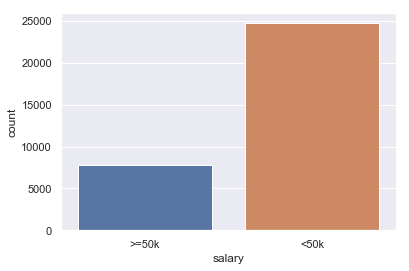

In [5]:
sns.countplot(df.salary);

# <center> Pre-processing
- Replace categories with their numeric codes
- handle missing continuous values
- Select target variable
- Split train and validation sets

# Missings

In [6]:
df = df.dropna(axis='rows')

# Categories

In [7]:
cat  = df.select_dtypes(include=[object]).columns
num  = df.select_dtypes(exclude=[object, 'datetime64','timedelta64']).columns
time = df.select_dtypes(include=['datetime64']).columns

print("\nNumerical features:\n", num.values)
print("\nCategorical features:\n", cat.values)
print("\nDate/time features:\n", time.values)


Numerical features:
 ['age' 'fnlwgt' 'education-num' 'capital-gain' 'capital-loss'
 'hours-per-week']

Categorical features:
 ['workclass' 'education' 'marital-status' 'occupation' 'relationship'
 'race' 'sex' 'native-country' 'salary']

Date/time features:
 []


In [8]:
df[cat] = df[cat].apply(LabelEncoder().fit_transform)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
1,44,4,236746,12,14.0,0,4,1,4,1,10520,0,45,39,1
3,38,5,112847,14,15.0,2,10,0,1,1,0,0,40,39,1
5,20,4,63210,11,9.0,4,6,3,4,1,0,0,15,39,0
8,46,4,328216,11,9.0,2,3,0,4,1,0,0,40,39,1
21,26,4,746432,11,9.0,4,6,3,2,1,0,0,48,39,0


# Split Train (80%) and validation (20%) ¡STRATIFIED!

In [9]:
x = df.drop("salary", axis="columns")
y = df["salary"]

x_train, x_valid, y_train, y_valid = train_test_split(x, y,
                                                      test_size=0.2,
                                                      stratify=y, 
                                                      random_state=0)

# Train Decission Tree

In [10]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [11]:
#plot_tree(model);

# Use Decission Tree to prect new data

In [12]:
preds = model.predict(x_valid)
preds

array([0, 1, 0, ..., 1, 0, 1])

# Metrics

Accuracy (Caution): 80.60663209178061
Balanced accuracy:  74.25686644925284


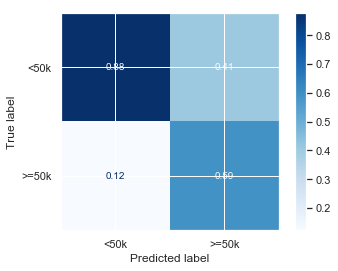

In [13]:
print("Accuracy (Caution):", accuracy_score(y_valid, preds)*100)
print("Balanced accuracy: ", balanced_accuracy_score(y_valid, preds)*100)
plot_confusion_matrix(model, x_valid, y_valid, display_labels=["<50k", ">=50k"],
                      cmap=plt.cm.Blues, normalize="pred");

# Feature importance

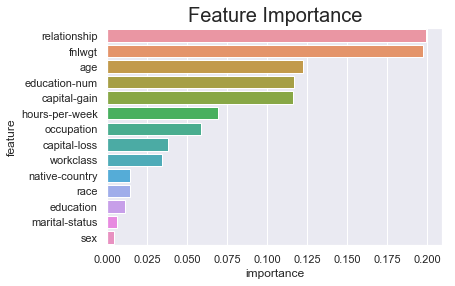

In [14]:
fi = pd.DataFrame({
      'feature':     x.columns,
      'importance':  model.feature_importances_
     }).sort_values('importance', ascending=False).reset_index(drop=True)

sns.barplot(x=fi.importance, y=fi.feature).set_title("Feature Importance",  fontsize=20);

# [Permutation Feature Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html) (Better, but slower)
Otra forma de calcular las varaibles más importantes.

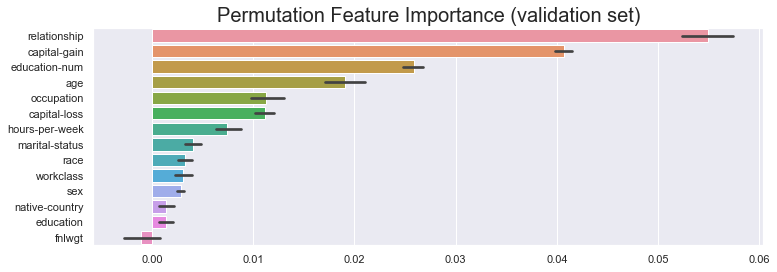

In [15]:
# Compute Permutation Feature Importance
pfi = permutation_importance(model, x_valid, y_valid, n_repeats=10, random_state=0, n_jobs=-1)

# Clean data
sorted_idx = pfi.importances_mean.argsort()[::-1]
pfi_df = pd.DataFrame(data=pfi.importances[sorted_idx].T, columns=x_valid.columns[sorted_idx])

# Plot (This can be barplot, boxplot, violinplot,...)
plt.figure(figsize=(12,4))
sns.barplot(data=pfi_df, orient="h").set_title("Permutation Feature Importance (validation set)",  fontsize=20);

# [Partial Dependence Plot](https://christophm.github.io/interpretable-ml-book/pdp.html)

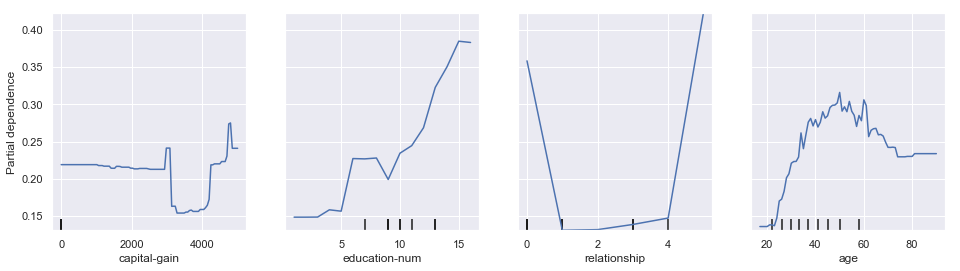

In [16]:
fig, ax = plt.subplots(figsize=(16, 4))
plot_partial_dependence(estimator=model,
                        X=x_train,          # raw predictors data.
                        features=["capital-gain", "education-num", "relationship", "age"],
                        grid_resolution=100, # number of values to plot on x axis
                        n_cols=4,
                        ax=ax,
                        n_jobs=-1           # Faster with all CPU cores
                       );

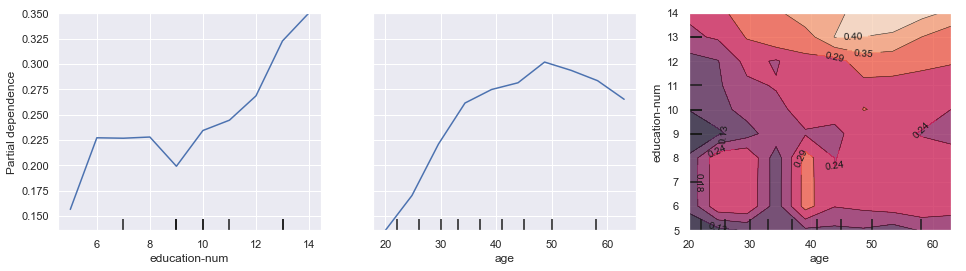

In [17]:
fig, ax = plt.subplots(figsize=(16, 4))
plot_partial_dependence(estimator=model,
                        X=x_train,
                        features=["education-num", "age", ("age", "education-num")],
                        grid_resolution=10,
                        ax=ax,
                        n_jobs=-1
                       );

# <center>FIN